___

<a href='http://www.pieriandata.com'><img src='../Pierian_Data_Logo.png'/></a>
___
<center><em>Copyright Pierian Data</em></center>
<center><em>For more information, visit us at <a href='http://www.pieriandata.com'>www.pieriandata.com</a></em></center>
# RNN Example for Time Series

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

## Data
https://fred.stlouisfed.org/series/S4248SM144NCEN

In [7]:
df = pd.read_csv('hyderabad-us consulate-air-quality.csv',index_col='date',parse_dates=True)
# df.index.freq = 'MS'

In [8]:
df.head()

,pm25
date,
2021-11-01,155
2021-11-02,115
2021-11-03,67
2021-11-04,112
2021-11-05,115


In [9]:
df.columns = ['Sales']

<AxesSubplot:xlabel='date'>

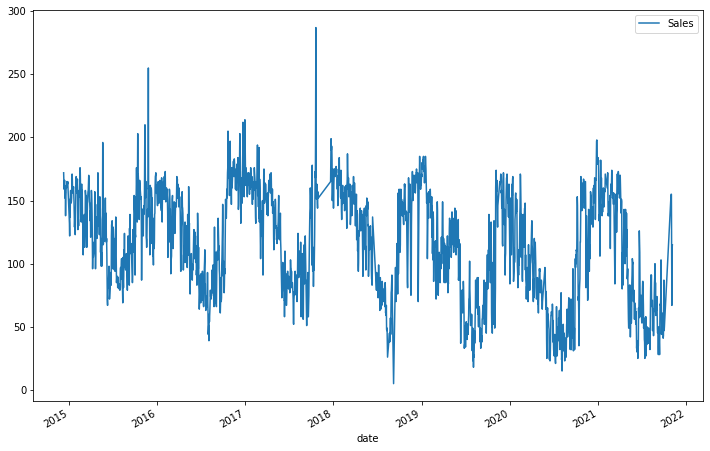

In [10]:
df.plot(figsize=(12,8))

In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose

<AxesSubplot:xlabel='date'>

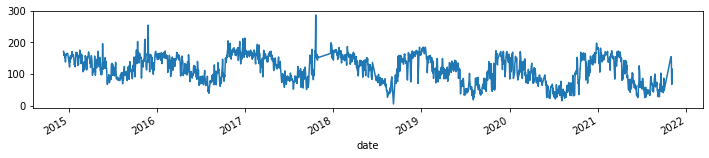

In [13]:
results = seasonal_decompose(df['Sales'], model='additive', period = 365)
results.observed.plot(figsize=(12,2))

<AxesSubplot:xlabel='date'>

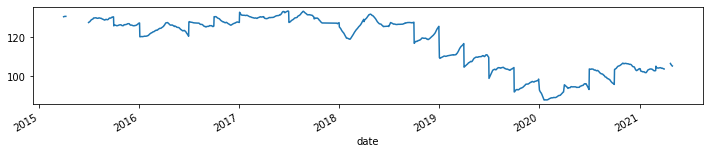

In [14]:
results.trend.plot(figsize=(12,2))

<AxesSubplot:xlabel='date'>

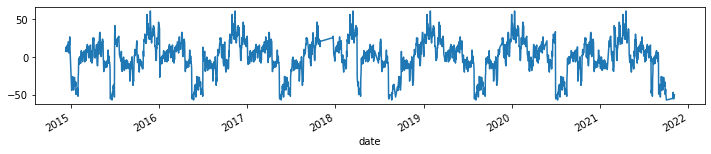

In [15]:
results.seasonal.plot(figsize=(12,2))

<AxesSubplot:xlabel='date'>

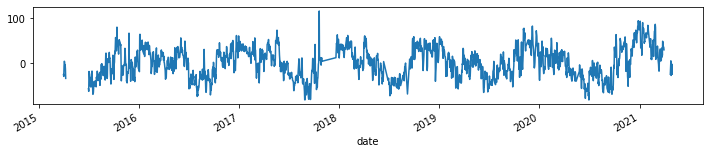

In [16]:
results.resid.plot(figsize=(12,2))

## Train Test Split

In [17]:
len(df)

2314

In [18]:
2314-365

1949

In [19]:
train = df.iloc[:1949]
test = df.iloc[1949:]

In [20]:
len(test)

365

## Scale Data

In [21]:
from sklearn.preprocessing import MinMaxScaler

In [22]:
scaler = MinMaxScaler()

In [23]:
# IGNORE WARNING ITS JUST CONVERTING TO FLOATS
# WE ONLY FIT TO TRAININ DATA, OTHERWISE WE ARE CHEATING ASSUMING INFO ABOUT TEST SET
scaler.fit(train)

MinMaxScaler()

In [24]:
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

# Time Series Generator

This class takes in a sequence of data-points gathered at
equal intervals, along with time series parameters such as
stride, length of history, etc., to produce batches for
training/validation.

#### Arguments
    data: Indexable generator (such as list or Numpy array)
        containing consecutive data points (timesteps).
        The data should be at 2D, and axis 0 is expected
        to be the time dimension.
    targets: Targets corresponding to timesteps in `data`.
        It should have same length as `data`.
    length: Length of the output sequences (in number of timesteps).
    sampling_rate: Period between successive individual timesteps
        within sequences. For rate `r`, timesteps
        `data[i]`, `data[i-r]`, ... `data[i - length]`
        are used for create a sample sequence.
    stride: Period between successive output sequences.
        For stride `s`, consecutive output samples would
        be centered around `data[i]`, `data[i+s]`, `data[i+2*s]`, etc.
    start_index: Data points earlier than `start_index` will not be used
        in the output sequences. This is useful to reserve part of the
        data for test or validation.
    end_index: Data points later than `end_index` will not be used
        in the output sequences. This is useful to reserve part of the
        data for test or validation.
    shuffle: Whether to shuffle output samples,
        or instead draw them in chronological order.
    reverse: Boolean: if `true`, timesteps in each output sample will be
        in reverse chronological order.
    batch_size: Number of timeseries samples in each batch
        (except maybe the last one).

In [25]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [26]:
scaled_train

array([[0.53191489],
       [0.39007092],
       [0.21985816],
       ...,
       [0.55319149],
       [0.57446809],
       [0.5212766 ]])

In [27]:
# define generator
n_input = 30
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [28]:
len(scaled_train)

1949

In [29]:
len(generator) # n_input = 2

1919

In [30]:
scaled_train

array([[0.53191489],
       [0.39007092],
       [0.21985816],
       ...,
       [0.55319149],
       [0.57446809],
       [0.5212766 ]])

In [31]:
# What does the first batch look like?
X,y = generator[0]

In [32]:
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.53191489 0.39007092 0.21985816 0.37943262 0.39007092 0.29078014
 0.14893617 0.15957447 0.5248227  0.53191489 0.21631206 0.24468085
 0.18794326 0.15248227 0.14184397 0.15602837 0.10283688 0.08156028
 0.10992908 0.15957447 0.13475177 0.11347518 0.08156028 0.16666667
 0.22340426 0.22340426 0.21985816 0.24822695 0.34751773 0.23049645]
Predict this y: 
 [[0.13829787]]


In [33]:
# Let's redefine to get 12 months back and then predict the next month out
n_input = 12
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [34]:
# What does the first batch look like?
X,y = generator[0]

In [35]:
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.53191489 0.39007092 0.21985816 0.37943262 0.39007092 0.29078014
 0.14893617 0.15957447 0.5248227  0.53191489 0.21631206 0.24468085]
Predict this y: 
 [[0.18794326]]


### Create the Model

In [36]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [37]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [38]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               40800     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [39]:
# fit model
model.fit_generator(generator,epochs=50)

C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
1937/1937 [==============================] - 8s 3ms/step - loss: 0.0079
Epoch 2/50
1937/1937 [==============================] - 6s 3ms/step - loss: 0.0048
Epoch 3/50
1937/1937 [==============================] - 6s 3ms/step - loss: 0.0043
Epoch 4/50
1937/1937 [==============================] - 6s 3ms/step - loss: 0.0042
Epoch 5/50
1937/1937 [==============================] - 6s 3ms/step - loss: 0.0043
Epoch 6/50
1937/1937 [==============================] - 7s 4ms/step - loss: 0.0042
Epoch 7/50
1937/1937 [==============================] - 11s 6ms/step - loss: 0.0042
Epoch 8/50
1937/1937 [==============================] - 7s 4ms/step - loss: 0.0041
Epoch 9/50
1937/1937 [==============================] - 7s 4ms/step - loss: 0.0041
Epoch 10/50
1937/1937 [==============================] - 9s 5ms/step - loss: 0.0041
Epoch 11/50
1937/1937 [==============================] - 8s 4ms/step - loss: 0.0041
Epoch 12/50
1937/1937 [==============================] - 7s 4ms/step - loss: 0.0041


In [40]:
model.history.history.keys()

dict_keys(['loss'])

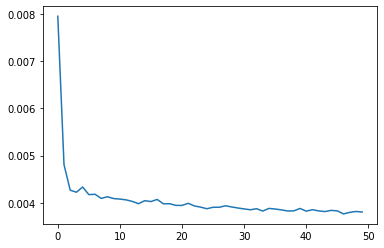

In [41]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

## Evaluate on Test Data

In [42]:
first_eval_batch = scaled_train[-12:]

In [43]:
first_eval_batch

array([[0.4787234 ],
       [0.5070922 ],
       [0.42198582],
       [0.45744681],
       [0.4822695 ],
       [0.5070922 ],
       [0.4964539 ],
       [0.53546099],
       [0.58156028],
       [0.55319149],
       [0.57446809],
       [0.5212766 ]])

In [44]:
first_eval_batch = first_eval_batch.reshape((1, n_input, n_features))

In [45]:
model.predict(first_eval_batch)

array([[0.51079345]], dtype=float32)

In [46]:
scaled_test[0]

array([0.56028369])

Now let's put this logic in a for loop to predict into the future for the entire test range.

----

In [47]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

In [48]:
current_batch.shape

(1, 12, 1)

In [49]:
current_batch

array([[[0.4787234 ],
        [0.5070922 ],
        [0.42198582],
        [0.45744681],
        [0.4822695 ],
        [0.5070922 ],
        [0.4964539 ],
        [0.53546099],
        [0.58156028],
        [0.55319149],
        [0.57446809],
        [0.5212766 ]]])

In [50]:
np.append(current_batch[:,1:,:],[[[99]]],axis=1)

array([[[ 0.5070922 ],
        [ 0.42198582],
        [ 0.45744681],
        [ 0.4822695 ],
        [ 0.5070922 ],
        [ 0.4964539 ],
        [ 0.53546099],
        [ 0.58156028],
        [ 0.55319149],
        [ 0.57446809],
        [ 0.5212766 ],
        [99.        ]]])

**NOTE: PAY CLOSE ATTENTION HERE TO WHAT IS BEING OUTPUTED AND IN WHAT DIMENSIONS. ADD YOUR OWN PRINT() STATEMENTS TO SEE WHAT IS TRULY GOING ON!!**

In [51]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [52]:
test_predictions

[array([0.51079345], dtype=float32),
 array([0.508047], dtype=float32),
 array([0.5066835], dtype=float32),
 array([0.50115466], dtype=float32),
 array([0.4985254], dtype=float32),
 array([0.49832672], dtype=float32),
 array([0.4960023], dtype=float32),
 array([0.49694148], dtype=float32),
 array([0.49586552], dtype=float32),
 array([0.49646798], dtype=float32),
 array([0.4982741], dtype=float32),
 array([0.49737284], dtype=float32),
 array([0.49524522], dtype=float32),
 array([0.49354097], dtype=float32),
 array([0.49240926], dtype=float32),
 array([0.491141], dtype=float32),
 array([0.49005392], dtype=float32),
 array([0.48904014], dtype=float32),
 array([0.48809433], dtype=float32),
 array([0.4873388], dtype=float32),
 array([0.48662272], dtype=float32),
 array([0.48602802], dtype=float32),
 array([0.48559913], dtype=float32),
 array([0.485197], dtype=float32),
 array([0.4846345], dtype=float32),
 array([0.48396116], dtype=float32),
 array([0.48326695], dtype=float32),
 array([0.482

In [53]:
scaled_test

array([[0.56028369],
       [0.54609929],
       [0.53191489],
       [0.54609929],
       [0.4964539 ],
       [0.47163121],
       [0.30496454],
       [0.41843972],
       [0.41134752],
       [0.5248227 ],
       [0.5       ],
       [0.56737589],
       [0.60638298],
       [0.56382979],
       [0.5070922 ],
       [0.45390071],
       [0.58156028],
       [0.70212766],
       [0.54964539],
       [0.58865248],
       [0.57092199],
       [0.46099291],
       [0.5212766 ],
       [0.57092199],
       [0.53191489],
       [0.5177305 ],
       [0.5248227 ],
       [0.44326241],
       [0.29078014],
       [0.40780142],
       [0.4893617 ],
       [0.42907801],
       [0.43971631],
       [0.42198582],
       [0.41489362],
       [0.4929078 ],
       [0.4751773 ],
       [0.5       ],
       [0.4822695 ],
       [0.54609929],
       [0.66666667],
       [0.72695035],
       [0.5212766 ],
       [0.55673759],
       [0.56737589],
       [0.41134752],
       [0.40425532],
       [0.382

## Inverse Transformations and Compare

In [54]:
true_predictions = scaler.inverse_transform(test_predictions)

In [55]:
true_predictions

array([[149.04375219],
       [148.26924968],
       [147.88475502],
       [146.32561445],
       [145.58416587],
       [145.5281347 ],
       [144.87264484],
       [145.13749653],
       [144.83407772],
       [145.00396973],
       [145.51329279],
       [145.25913972],
       [144.65915155],
       [144.17855424],
       [143.85941106],
       [143.50175959],
       [143.19520599],
       [142.90931845],
       [142.64260101],
       [142.42954475],
       [142.22760731],
       [142.0599004 ],
       [141.93895477],
       [141.82555616],
       [141.66692585],
       [141.47704852],
       [141.2812798 ],
       [141.08325034],
       [140.88591844],
       [140.69098175],
       [140.5004741 ],
       [140.31773198],
       [140.14284784],
       [139.97709072],
       [139.82248604],
       [139.67770594],
       [139.5369935 ],
       [139.39644915],
       [139.25556862],
       [139.11492342],
       [138.97500938],
       [138.83617109],
       [138.69883716],
       [138

In [56]:
test

,Sales
date,
2016-03-27,163
2016-03-28,159
2016-03-29,155
2016-03-30,159
2016-03-31,145
...,...
2014-12-24,165
2014-12-25,165
2014-12-26,163


In [57]:
# IGNORE WARNINGS
test['Predictions'] = true_predictions

<ipython-input-57-53e06c23926f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


In [58]:
test

,Sales,Predictions
date,,
2016-03-27,163,149.043752
2016-03-28,159,148.269250
2016-03-29,155,147.884755
2016-03-30,159,146.325614
2016-03-31,145,145.584166
...,...,...
2014-12-24,165,130.674766
2014-12-25,165,130.673362
2014-12-26,163,130.671975


<AxesSubplot:xlabel='date'>

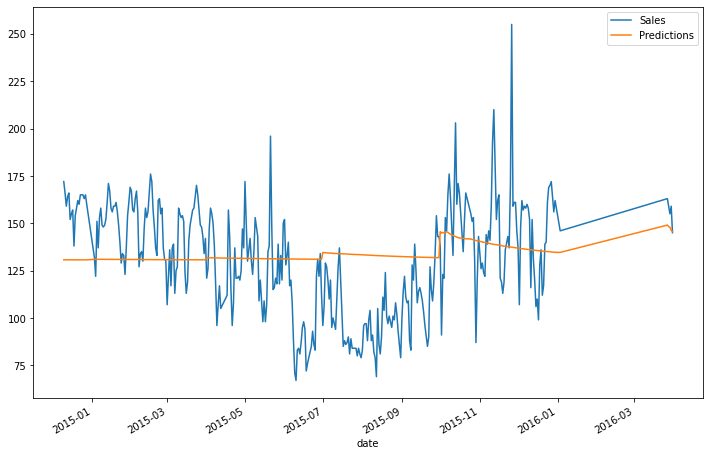

In [59]:
test.plot(figsize=(12,8))

# Saving and Loading Models

In [54]:
model.save('my_rnn_model.h5')

## load a model

In [55]:
from keras.models import load_model
new_model = load_model('my_rnn_model.h5')

In [56]:
new_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
